1. Design a process that stays in the interval $[a,b]$ and mean-reverts around $\frac{b-a}{с}$, $c \sim \mathcal{U}(a,b)$.

Generate a path and plot it in graph and add the mean line.

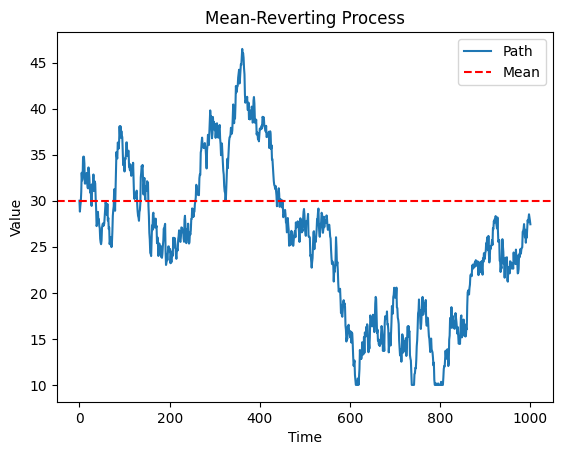

In [35]:
import numpy as np
import matplotlib.pyplot as plt

class MeanRevertingProcess:
    def __init__(self, a, b, n_steps=1000):
        """
        Initialize the mean-reverting process with given parameters.
        
        :param a: Lower bound of the interval.
        :param b: Upper bound of the interval.
        :param n_steps: Number of time steps to simulate.
        """
        self.a = a
        self.b = b
        self.n_steps = n_steps
        self.mean_revert = (b - a) / np.random.uniform(a, b)

    def simulate(self):
        """
        Simulate the mean-reverting process over `n_steps` and return the path.

        :return: The list of values representing the path and the mean.
        """
        path = [self._initial_value()]
        
        for _ in range(self.n_steps):
            movement = np.random.normal(0, 1) * self.mean_revert
            current_value = self._clamp(path[-1] + movement)
            path.append(current_value)
        
        return path

    def _initial_value(self):
        """
        Calculate the initial value (the midpoint of the interval).
        
        :return: The initial value.
        """
        return (self.a + self.b) / 2

    def _clamp(self, value):
        """
        Ensure the value stays within the interval [a, b].
        
        :param value: The value to clamp.
        :return: The clamped value.
        """
        return max(self.a, min(self.b, value))

    def plot(self, path):
        """
        Plot the generated mean-reverting path.

        :param path: The path of values to plot.
        """
        mean_value = (self.a + self.b) / 2
        plt.plot(path, label='Path')
        plt.axhline(y=mean_value, color='r', linestyle='--', label='Mean')
        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Mean-Reverting Process')
        plt.show()

# Parameters
a = 10
b = 50
n_steps = 1000

# Simulate the mean-reverting process
process = MeanRevertingProcess(a, b, n_steps)
path = process.simulate()

# Plot the path
process.plot(path)

2. Simulate a Cox-Ingersoll-Ross (CIR) process
$$
dX_t = (6 - 2X_t)dt + θ\sqrt{X_t}dW_t, X(0)=1,
$$
where $θ = θ_1 = 1$ for $t < τ_0 = 0.6$ and $θ = θ_2$ for $t ≥ τ_0$, $t \in (0, 1)$.

Plot the simulated path, plot the shape of statistic $|\hat{D}_k|$ and
identify the change-point $k_0$ on a time-serie and compare result with $\tau_0$.

**Hint (Iacus, 2008, p. 212).** Consider the $\sigma(x)$ is constant and $b(x)$ can be estimated
$$
\hat{b}_n(x) = \frac{\sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)(X_{i+1}-X_i)} {\Delta_n \sum_{i=0}^{n-1} K\left(\frac{x-X_i}{h_n}\right)},
$$
then use residuals
$$
Z_i = \frac{(X_{i+1} - X_i) - \hat{b}(X_i)\Delta_n}{\sqrt{\Delta_n}},
$$
and compute the statistic
$$
\hat{V}_k = \left(\frac{k(n-k)}{n^2}\right)^{1/2} \left(\frac{\hat{S}_{n-k}}{n-k}
- \frac{\hat{S}_k}{k}\right)
 = \frac{\hat{S}_n \hat{D}_k}{\sqrt{n-k}},
$$
where
$\hat{S}_k = \sum_{i=1}^k \hat{Z}_i^2$,
$\hat{S}_{n-k} = \sum_{i=k+1}^n \hat{Z}_i^2$, and $\hat{D}_k = \frac kn - \frac{\hat{S}_k}{\hat{S}_n}.$

Finally the change-point is identifed as the solution to
$$
\hat{k}_0 = \arg \min_k |\hat{D}_k|.
$$

Expected result is:

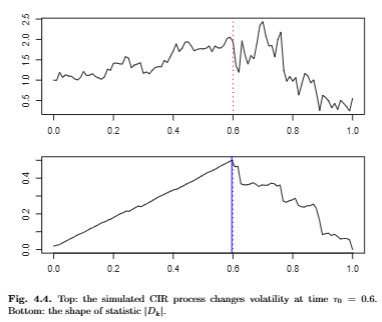

https://forecastegy.com/posts/change-point-detection-time-series-python/

https://github.com/amanahuja/change-detection-tutorial

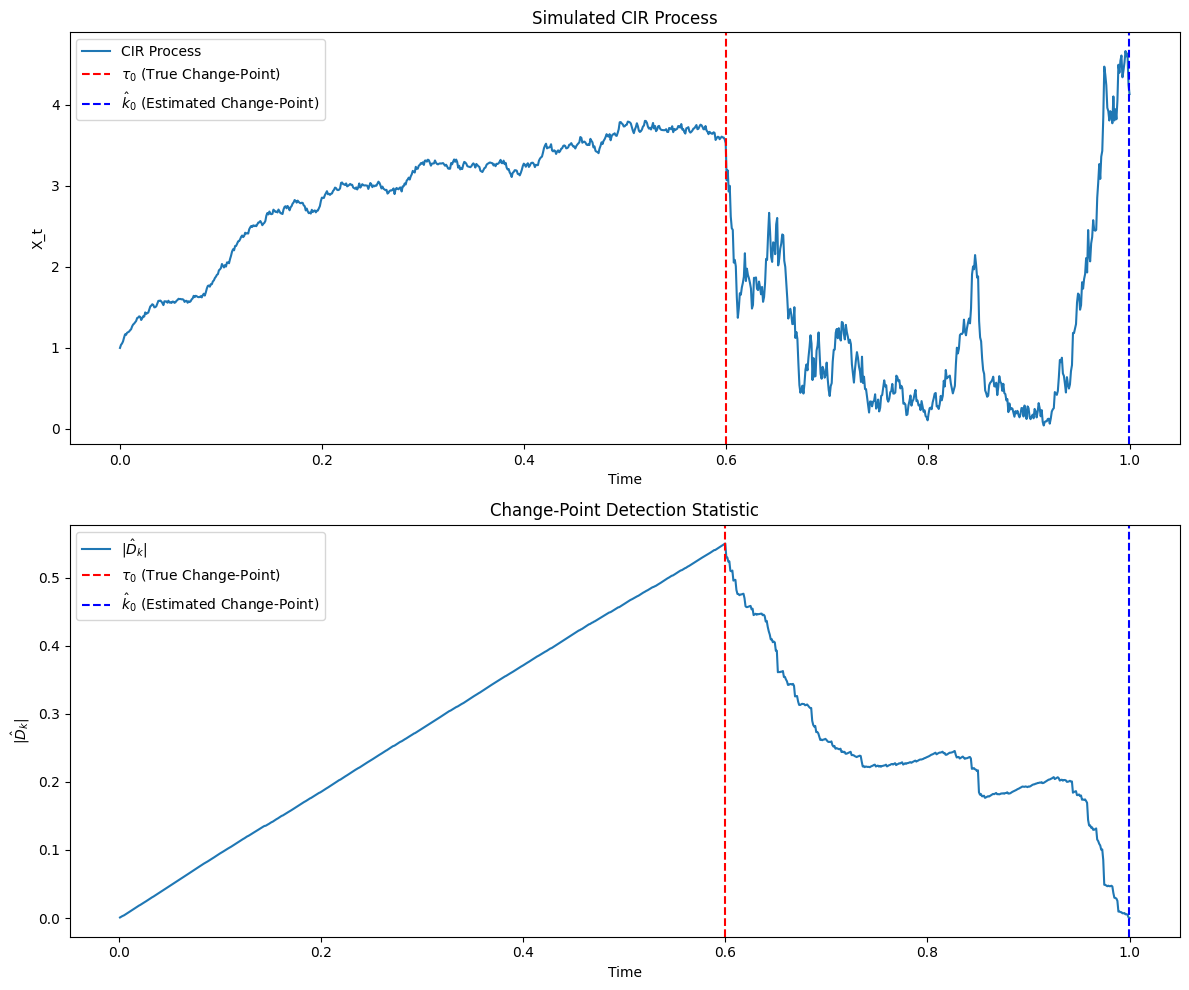

(0.6, np.float64(0.999))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.signal import find_peaks

# Parameters 
theta1 = 0.5  # Volatility before tau_0
theta2 = 5  # Volatility after tau_0 (chosen distinctly for illustration)
kappa = 2.0   # Mean-reversion speed
mu = 6.0      # Mean level
x0 = 1.0      # Initial condition
tau_0 = 0.6   # Change-point in time
T = 1.0       # Time horizon
dt = 0.001    # Time step
n_steps = int(T / dt)

# Time vector
time = np.linspace(0, T, n_steps + 1)

# CIR Process simulation
X = np.zeros(n_steps + 1)
X[0] = x0
np.random.seed(0)

for i in range(1, n_steps + 1):
    theta = theta1 if time[i] < tau_0 else theta2
    dW = np.sqrt(dt) * np.random.normal()
    X[i] = X[i-1] + kappa * (mu - X[i-1]) * dt + theta * np.sqrt(max(X[i-1], 0)) * dW

# Drift estimation and residuals
h_n = 0.1  # Bandwidth for kernel smoothing
Z = np.zeros(n_steps)

for i in range(n_steps):
    kernel_weights = np.exp(-((X[i] - X[:n_steps]) / h_n) ** 2)
    b_hat = np.sum(kernel_weights * (X[1:n_steps+1] - X[:n_steps])) / (dt * np.sum(kernel_weights))
    Z[i] = (X[i+1] - X[i] - b_hat * dt) / np.sqrt(dt)

# Compute statistics to identify change-point
S_k = np.cumsum(Z ** 2)
D_k = (np.arange(1, n_steps + 1) / n_steps) - (S_k / S_k[-1])
D_k_abs = np.abs(D_k)

# Identify the change-point
k0_estimated = np.argmin(D_k_abs)

# Plotting the CIR process, |D_k|, and estimated change-point
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

# Plot the CIR path
axs[0].plot(time, X, label="CIR Process")
axs[0].axvline(tau_0, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axs[0].axvline(time[k0_estimated], color="blue", linestyle="--", label=r"$\hat{k}_0$ (Estimated Change-Point)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("X_t")
axs[0].legend()
axs[0].set_title("Simulated CIR Process")

# Plot |D_k|
axs[1].plot(time[1:], D_k_abs, label=r"$|\hat{D}_k|$")
axs[1].axvline(tau_0, color="red", linestyle="--", label=r"$\tau_0$ (True Change-Point)")
axs[1].axvline(time[k0_estimated], color="blue", linestyle="--", label=r"$\hat{k}_0$ (Estimated Change-Point)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel(r"$|\hat{D}_k|$")
axs[1].legend()
axs[1].set_title("Change-Point Detection Statistic")

plt.tight_layout()
plt.show()

tau_0, time[k0_estimated]

3. Simulate and plot 100 trajectories of the process
$$
dX_t = (0.03tX_t – X^3_t)dt + 0.1dW_t
$$
with the 1st Milstein scheme, $x_0=0$, $t_0=0$, $T=100$, and $\Delta t=0.01$.

Add an average trajectory and confidence interval on the graph.

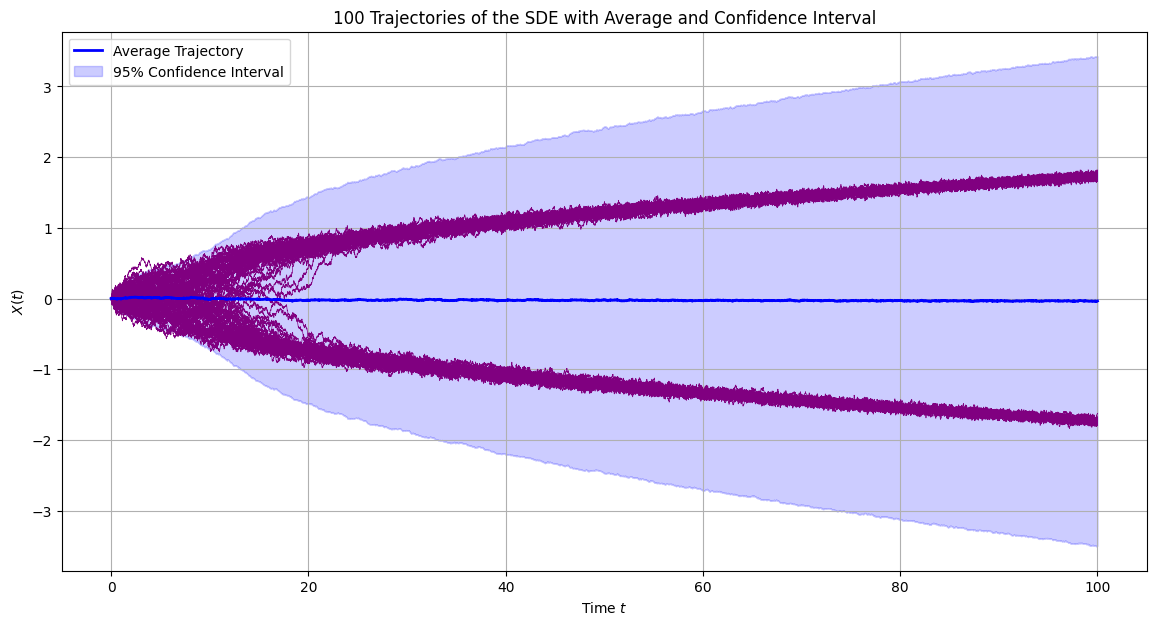

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
x0 = 0.0          # Initial condition
t0 = 0.0          # Start time
T = 100.0         # End time
Delta_t = 0.01    # Time step size
N_steps = int((T - t0) / Delta_t)
t = np.linspace(t0, T, N_steps + 1)  # Time grid

N_trajectories = 100  # Number of trajectories

# Drift and diffusion functions
def mu(t, x):
    """ Drift term of the SDE """
    return 0.03 * t * x - x**3

def sigma(t, x):
    """ Diffusion term of the SDE """
    return 0.1

def simulate_sde(N_trajectories, N_steps, Delta_t, mu, sigma, t, x0):
    """ Simulate N_trajectories of the SDE over N_steps """
    X = np.zeros((N_trajectories, N_steps + 1))
    X[:, 0] = x0
    
    for i in range(N_trajectories):
        for n in range(N_steps):
            t_n = t[n]
            X_n = X[i, n]
            dW_n = np.sqrt(Delta_t) * np.random.randn()
            X[i, n+1] = X_n + mu(t_n, X_n) * Delta_t + sigma(t_n, X_n) * dW_n
    return X

def compute_statistics(X):
    """ Compute the mean and standard deviation of the trajectories """
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    return X_mean, X_std

def plot_trajectories(t, X, X_mean, X_std):
    """ Plot the SDE trajectories with the mean and confidence interval """
    plt.figure(figsize=(14, 7))

    # Plot all individual trajectories
    for i in range(X.shape[0]):
        plt.plot(t, X[i, :], color='purple', linewidth=0.5)

    # Plot the average trajectory
    plt.plot(t, X_mean, color='blue', label='Average Trajectory', linewidth=2)

    # Plot the 95% confidence interval
    plt.fill_between(t, X_mean - 2*X_std, X_mean + 2*X_std, color='blue', alpha=0.2, label='95% Confidence Interval')

    plt.title('100 Trajectories of the SDE with Average and Confidence Interval')
    plt.xlabel('Time $t$')
    plt.ylabel('$X(t)$')
    plt.legend()
    plt.grid(True)
    plt.show()

# Simulation
X = simulate_sde(N_trajectories, N_steps, Delta_t, mu, sigma, t, x0)

# Compute statistics
X_mean, X_std = compute_statistics(X)

# Plot results
plot_trajectories(t, X, X_mean, X_std)

4. Implement a non-parametric drift and diffusion estimators for the Ornstein-Uhlenbeck model
$$
dX_t = (θ_1 - θ_2X_t)dt + θ_3 dW_t,
X(0) = 10,  θ = (0, 3, 2).
$$

Use
*   uniform kernel $K(u) = 1/2$,
*   Epanechnikov (parabolic) kernel $K(u) = \frac{3}{4}(1 - u^2)$,
*   Gaussian kernel $K(u) = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2}u^2\right)$,

and plot the estimations on the graph.


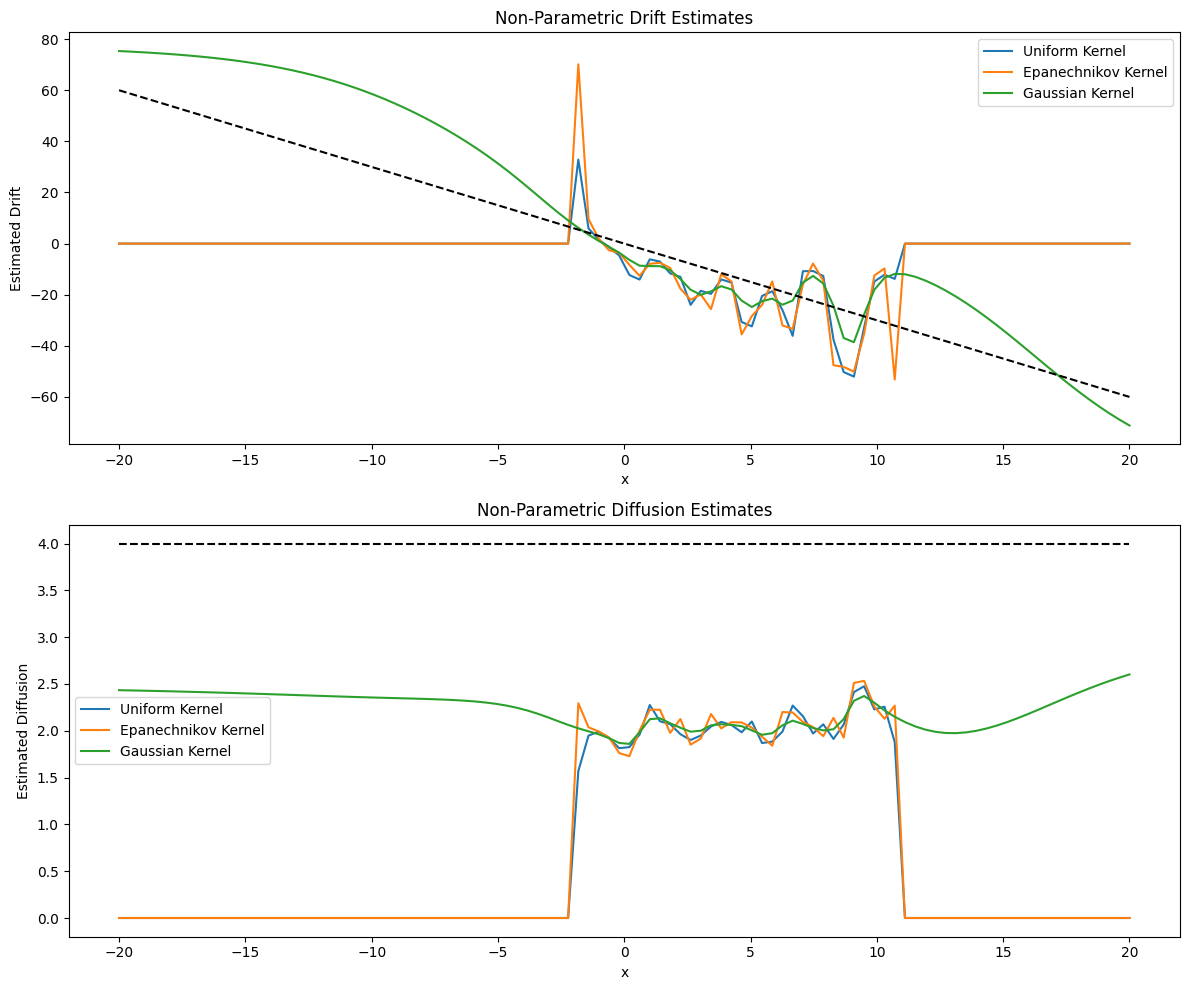

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for OU process
theta1 = 0.0   # Mean level
theta2 = 3.0   # Speed of reversion
theta3 = 2.0   # Diffusion term (volatility)
x0 = 10.0      # Initial condition
T = 1.0        # Time horizon
dt = 0.001     # Time step
n_steps = int(T / dt)

# Time vector and simulate the OU process
time = np.linspace(0, T, n_steps + 1)
X = np.zeros(n_steps + 1)
X[0] = x0
np.random.seed(0)

for i in range(1, n_steps + 1):
    dW = np.sqrt(dt) * np.random.normal()
    X[i] = X[i-1] + (theta1 - theta2 * X[i-1]) * dt + theta3 * dW

# Define kernels
def uniform_kernel(u):
    return 0.5 * (np.abs(u) <= 1)

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) * (np.abs(u) <= 1)

def gaussian_kernel(u):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * u**2)

# Non-parametric estimation function for drift and diffusion
def estimate_drift_diffusion(X, kernel_func, x_points, h):
    drift_estimates = np.zeros(len(x_points))
    diffusion_estimates = np.zeros(len(x_points))
    
    for j, x in enumerate(x_points):
        # Kernel weights
        weights = kernel_func((x - X[:-1]) / h)
        
        # Avoid division by zero or very small numbers
        weight_sum = np.sum(weights)
        if weight_sum == 0:
            drift_estimates[j] = 0
            diffusion_estimates[j] = 0
        else:
            drift_estimates[j] = np.sum(weights * (X[1:] - X[:-1])) / (dt * weight_sum)
            diffusion_estimates[j] = np.sqrt(np.sum(weights * (X[1:] - X[:-1])**2) / (dt * weight_sum))
    
    return drift_estimates, diffusion_estimates

# Set up x_points and bandwidth
x_points = np.linspace(-20, 20, 100)
h = 0.5  # Adjust bandwidth to smaller value

# Compute estimates for each kernel
drift_uniform, diff_uniform = estimate_drift_diffusion(X, uniform_kernel, x_points, h)
drift_epanechnikov, diff_epanechnikov = estimate_drift_diffusion(X, epanechnikov_kernel, x_points, h)
drift_gaussian, diff_gaussian = estimate_drift_diffusion(X, gaussian_kernel, x_points, h)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

a_true = -theta2 * x_points
b_true = theta3**2 * np.ones_like(x_points)

# Plot drift estimates
axs[0].plot(x_points, drift_uniform, label="Uniform Kernel")
axs[0].plot(x_points, drift_epanechnikov, label="Epanechnikov Kernel")
axs[0].plot(x_points, drift_gaussian, label="Gaussian Kernel")
axs[0].set_xlabel("x")
axs[0].set_ylabel("Estimated Drift")
axs[0].set_title("Non-Parametric Drift Estimates")
axs[0].legend()

# Plot diffusion estimates
axs[1].plot(x_points, diff_uniform, label="Uniform Kernel")
axs[1].plot(x_points, diff_epanechnikov, label="Epanechnikov Kernel")
axs[1].plot(x_points, diff_gaussian, label="Gaussian Kernel")
axs[1].set_xlabel("x")
axs[1].set_ylabel("Estimated Diffusion")
axs[1].set_title("Non-Parametric Diffusion Estimates")
axs[1].legend()

# Plot true values
axs[0].plot(x_points, a_true, 'k--', label='True Drift')
axs[1].plot(x_points, b_true, 'k--', label='True Diffusion')

plt.tight_layout()
plt.show()

The plots show the non-parametric drift and diffusion estimates for the Ornstein-Uhlenbeck process using three different kernels: uniform, Epanechnikov, and Gaussian. Each kernel produces slightly different estimates, with the Gaussian kernel generally yielding smoother curves due to its infinite support, while the uniform and Epanechnikov kernels are more localized.

The results demonstrate the impact of kernel choice on non-parametric estimation, with differences especially evident in regions with sparse data or higher variance.

5. Estimate the parameters of a random process. As candidates use
*   Ornstein-Uhlenbeck process,
*   Geometric Brownian motion process,
*   Cox-Ingersoll-Ross process.

Plot three models in a graph and choose the best one. Provide the proof of your solution.

Time-series (*. csv) in the [folder](https://drive.google.com/drive/folders/1tzHl3-7jMtRiGgFe5suqT2CzftZ0o9cB?usp=sharing).

Estimated CIR parameters:
θ = 1.0
μ = 0.5094900789686635
σ = 0.1
MSE Ornstein-Uhlenbeck: 0.00011558989268804078
MSE Geometric Brownian Motion: 0.0008373351307005157
MSE Cox-Ingersoll-Ross: 0.000893997433456419


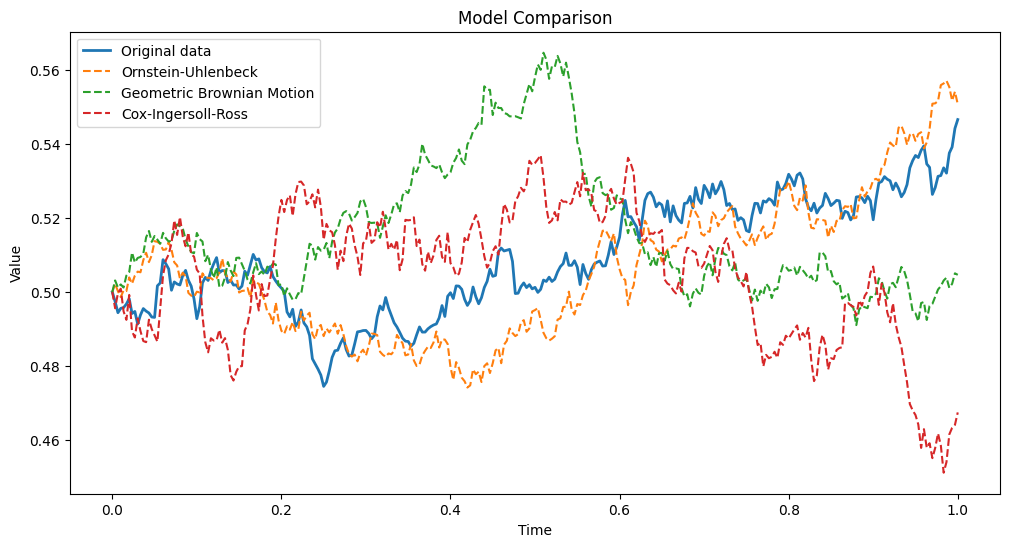

In [43]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('1.csv')
df.columns = ['Time', 'Value']
time = df['Time'].values
values = df['Value'].values
dt = np.diff(time)

# Define log-likelihood for Ornstein-Uhlenbeck process
def ou_log_likelihood(params, x, dt):
    theta, mu, sigma = params
    n = len(x) - 1
    likelihood = 0
    for i in range(n):
        m = x[i] * np.exp(-theta * dt[i]) + mu * (1 - np.exp(-theta * dt[i]))
        s2 = (sigma**2 / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i]))
        likelihood += -0.5 * np.log(2 * np.pi * s2) - ((x[i+1] - m)**2) / (2 * s2)
    return -likelihood

# Initial guess for parameters
initial_guess = [1.0, np.mean(values), 0.1]

# Optimize OU parameters
result_ou = minimize(ou_log_likelihood, initial_guess, args=(values, dt), bounds=((1e-5, None), (None, None), (1e-5, None)))
theta_ou, mu_ou, sigma_ou = result_ou.x

# Calculate log-returns for GBM model
log_returns = np.diff(np.log(values))
mu_gbm = np.mean(log_returns) / np.mean(dt)
sigma_gbm = np.std(log_returns) / np.sqrt(np.mean(dt))

# Method of Moments for CIR parameters
def cir_method_of_moments(x, dt):
    X_t = x[:-1]
    X_tp = x[1:]
    mean_X_t = np.mean(X_t)
    mean_X_tp = np.mean(X_tp)
    var_X_tp = np.var(X_tp)

    def moments_error(params):
        theta, mu, sigma = params
        if theta <= 0 or mu <= 0 or sigma <= 0:
            return np.inf
        E_X_tp = mean_X_t * np.exp(-theta * dt.mean()) + mu * (1 - np.exp(-theta * dt.mean()))
        Var_X_tp = (sigma**2 * mean_X_t) / (2 * theta) * (1 - np.exp(-2 * theta * dt.mean()))
        error1 = (E_X_tp - mean_X_tp)**2
        error2 = (Var_X_tp - var_X_tp)**2
        return error1 + error2

    initial_guess = [1.0, np.mean(values), 0.1]
    result = minimize(moments_error, initial_guess, bounds=((1e-5, None), (1e-5, None), (1e-5, None)))
    if result.success:
        return result.x
    else:
        raise RuntimeError("Optimization failed for method of moments.")

# Optimize CIR parameters
theta_cir, mu_cir, sigma_cir = cir_method_of_moments(values, dt)
print(f"Estimated CIR parameters:\nθ = {theta_cir}\nμ = {mu_cir}\nσ = {sigma_cir}")

# Simulate CIR process
def simulate_cir(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        mean = x[i-1] * np.exp(-theta * dt[i-1]) + mu * (1 - np.exp(-theta * dt[i-1]))
        variance = (sigma**2 * x[i-1] / (2 * theta)) * (1 - np.exp(-2 * theta * dt[i-1]))
        x[i] = mean + np.sqrt(variance) * np.random.normal()
        x[i] = max(x[i], 0)
    return x

# Simulate OU process
def simulate_ou(theta, mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] + theta * (mu - x[i-1]) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal()
    return x

# Simulate GBM process
def simulate_gbm(mu, sigma, x0, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0
    for i in range(1, n_steps):
        x[i] = x[i-1] * np.exp((mu - 0.5 * sigma**2) * dt[i-1] + sigma * np.sqrt(dt[i-1]) * np.random.normal())
    return x

# Simulate the processes
np.random.seed(123)
cir_sim = simulate_cir(theta_cir, mu_cir, sigma_cir, values[0], dt, len(values))
ou_sim = simulate_ou(theta_ou, mu_ou, sigma_ou, values[0], dt, len(values))
gbm_sim = simulate_gbm(mu_gbm, sigma_gbm, values[0], dt, len(values))

# Calculate Mean Squared Error for each model
mse_ou = np.mean((values - ou_sim)**2)
mse_gbm = np.mean((values - gbm_sim)**2)
mse_cir = np.mean((values - cir_sim)**2)

print(f"MSE Ornstein-Uhlenbeck: {mse_ou}")
print(f"MSE Geometric Brownian Motion: {mse_gbm}")
print(f"MSE Cox-Ingersoll-Ross: {mse_cir}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(time, values, label='Original data', linewidth=2)
plt.plot(time, ou_sim, label='Ornstein-Uhlenbeck', linestyle='--')
plt.plot(time, gbm_sim, label='Geometric Brownian Motion', linestyle='--')
plt.plot(time, cir_sim, label='Cox-Ingersoll-Ross', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Model Comparison')
plt.legend()
plt.show()